In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
import numpy as np
from itertools import permutations
from collections import Counter

def weighted_permutation_entropy(time_series, order:int=3, delay:int=1) -> float:
    """
    Calculate the weighted permutation entropy for a time series.
    
    Weighted permutation entropy (WPE) is a measure of complexity that takes into account 
    the amplitude variations within the ordinal patterns of a time series. It extends 
    the concept of permutation entropy by weighting each permutation pattern with the 
    variance of the values forming that pattern.
    
    Parameters:
    -----------
    time_series : array-like
        The input time series data.
    order : int, default=3
        The order of permutation entropy (embedding dimension). This determines the 
        length of patterns to search for in the time series.
    delay : int, default=1
        The delay between points in the time series when forming patterns (embedding delay).
    
    Returns:
    --------
    float
        The weighted permutation entropy value. Higher values indicate more complexity
        and randomness, while lower values suggest more regularity and predictability.
    """
    if not hasattr(time_series, '__iter__'):
        raise ValueError("Input time_series must be an iterable (e.g., list, numpy array).")
    if not isinstance(order, int) or order < 1:
        raise ValueError("Order must be a positive integer.")
    if not isinstance(delay, int) or delay < 1:
        raise ValueError("Delay must be a positive integer.")
    if len(time_series) < order * delay:
        raise ValueError("Time series length must be at least order * delay.")

    n = len(time_series)
    permutations_list = list(permutations(range(order))) # list of possible permutations of length order
    c = Counter() # counter for the occurences of each permutation
    weights = {p: 0.0 for p in permutations_list} # weights to compute the WPE instead of the vanilla PE
    
    for i in range(n - delay * (order - 1)):
        window = time_series[i:i + delay * order:delay]
        sorted_idx = tuple(np.argsort(window)) # we only care about the ordinal pattern
        var = np.var(window) # the weight of each permutation is the variance (following approach from https://doi.org/10.1103/PhysRevE.87.022911)
        c[sorted_idx] += 1 # update counter
        weights[sorted_idx] += var # add variance to weight

    total_weight = sum(weights.values())
    if total_weight == 0:
        return 0.0 # if variance = 0 we return 0.0 to avoid division by zero

    wpe = 0.0
    for p in permutations_list:
        w = weights[p] / total_weight # normalize weights
        # compute entropy term by term
        if w > 0:
            wpe -= w * np.log2(w)

    return wpe / np.log2(len(permutations_list)) # normalize by the number of permutations

def wpe_row(row):
    return weighted_permutation_entropy(row, order=3, delay=1)

In [10]:
harmonic = pd.read_parquet('synthetic_data_parquet/harmonic_dataset.parquet')
ou = pd.read_parquet('synthetic_data_parquet/ou_dataset.parquet')

In [ ]:
harmonic_wpe_series = harmonic.apply(wpe_row, axis=0)
ou_wpe_series = ou.apply(wpe_row, axis=0)

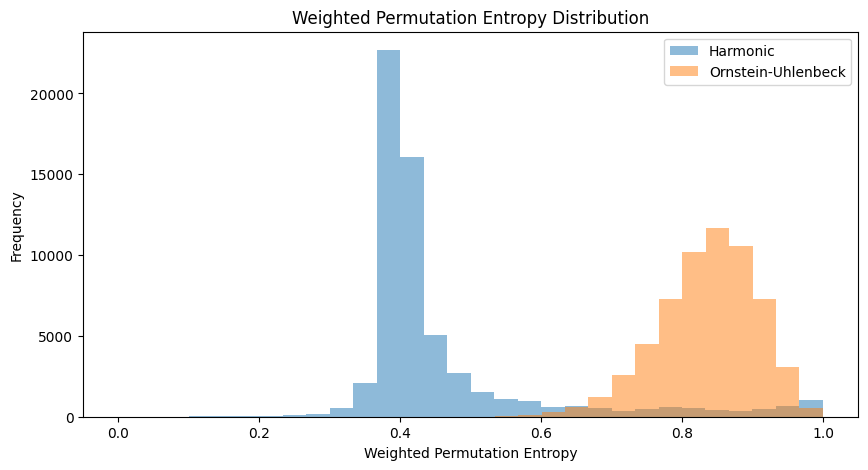

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(harmonic_wpe_series, bins=30, alpha=0.5, label='Harmonic')
plt.hist(ou_wpe_series, bins=30, alpha=0.5, label='Ornstein-Uhlenbeck')
plt.title('Weighted Permutation Entropy Distribution')
plt.xlabel('Weighted Permutation Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
square = np.ones((10,10))

hasattr(square, '__iter__')

True